In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

def plot_lung_segment(image, mask, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(image)
    ax.imshow(mask, alpha=0.4)
    ax.set_axis_off()

# Train Lung Segmentation

In [13]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from sklearn.metrics import roc_auc_score
from transform import lung_segmentation_transfrom
from model_data import ModelData
import pretrainedmodels
from datetime import datetime
from metrics import dice, iou
import pandas as pd
from layers import SaveFeature
from unet import Unet
from dataset import LungSegmentationDataset

In [5]:
PATH = Path('/home/dattran/data/xray-thesis/LungSegmentation')
IMAGE_DN = 'images'
MASK_DN = 'masks'

# models_name = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
models_name = '20190208-150639'
print(models_name)
model_path = PATH/'models'/models_name
model_path.mkdir(parents=True, exist_ok=True)

20190208-150639


In [11]:
import torchvision.transforms as transforms
from constant import IMAGENET_MEAN, IMAGENET_STD

class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

denorm = transforms.Compose([
    Denormalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.ToPILImage()
])

to_pil = transforms.ToPILImage()

In [6]:
# class LungSegmentationDataset(Dataset):

#     def __init__(self, image_names, mask_names, transform, path, size):
#         self.image_names = image_names
#         self.mask_names = mask_names
#         self.path = path
#         self.transform = transform
#         self.size = size

#     def __getitem__(self, i):
#         image_file = self.path/'images'/self.image_names[i]
#         mask_file = self.path/'masks'/self.mask_names[i]
        
#         image = Image.open(image_file).convert('RGB')
#         mask = Image.open(mask_file)

#         seed = random.randint(0, 2**32)
#         if self.transform:
#             random.seed(seed)
#             image = self.transform[0](image)
#             random.seed(seed)
#             mask = self.transform[1](mask)

#         return image, mask

#     def __len__(self):
#         return len(self.image_names)
    
#     @property
#     def sz(self):
#         return self.size


In [15]:
from torch.utils.data import DataLoader
def get_md(sz, bs):
    train = pd.read_csv(PATH/'train.csv', header=None).iloc[:, 1].values
    val = pd.read_csv(PATH/'val.csv', header=None).iloc[:, 1].values
    tfms = lung_segmentation_transfrom(sz)
    datasets = ImageData.get_ds(LungSegmentationDataset, (train, train), (val, val), tfms, path=PATH, size=sz)
    md = ModelData(PATH, datasets, bs, num_workers=4, classes=None)
    return md

def get_test(sz, bs, what='mont'):
    if what == 'mont':
        test = pd.read_csv(PATH/'test_mont.csv', header=None).iloc[:, 1].values
    elif what == 'jsrt':
        test = pd.read_csv(PATH/'test_jsrt.csv', header=None).iloc[:, 1].values
    
    _, tfm = lung_segmentation_transfrom(sz)
    dataset = LungSegmentationDataset(test, test, tfm, PATH, sz)
    return DataLoader(dataset, bs, num_workers=4)

md = get_md(128, 32)

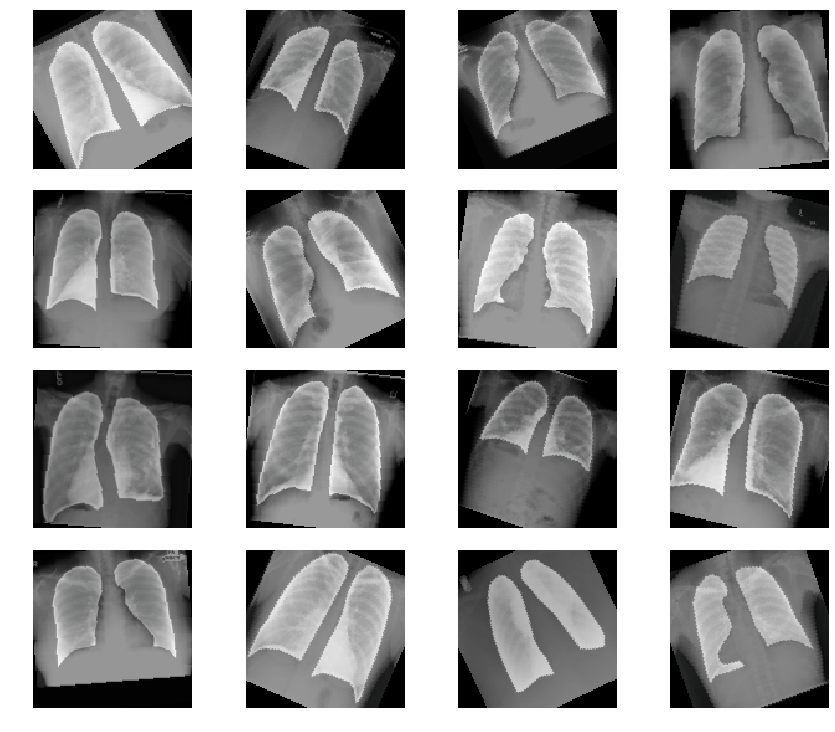

In [9]:
x, y = next(iter(md.trn_dl))
fig, axes = plt.subplots(4, 4, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax = show_img(denorm(x[i]), ax=ax)
    show_img(to_pil(y[i]), ax=ax, alpha=0.4)
plt.tight_layout(pad=0.1)

## Unet

In [17]:
def dice_s(preds, targets):
    return dice(torch.sigmoid(preds), targets)

def iou_s(preds, targets):
    return iou(torch.sigmoid(preds), targets)


In [43]:
class UnetBlock(nn.Module):

    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out // 2 # n_out is concat of up_out and x_out
        self.x_conv = nn.Conv2d(x_in, x_out, 1) # 1x1 conv
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        nn.ConvTranspose2d

    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p, x_p], dim=1) # concat along #filter
        return self.bn(F.relu(cat_p))


class Unet(nn.Module):

    def __init__(self, trained=False, model_name=None):
        super().__init__()

        if trained:
            assert model_name != None
            self.load_model(model_name)
        else:
            self.load_pretrained()

    def load_model(self, model_name):
        resnet = resnet50(False)
        self.backbone = nn.Sequential(*cut_model(resnet, 8))
        self.init_head()

        path = Path('/home/dattran/data/xray-thesis/LungSegmentation/models')
        state_dict = torch.load(path/model_name/'best.h5')
        self.load_state_dict(state_dict)

    def load_pretrained(self, torch=False):
        if torch:
            resnet = resnet50(True)
        else:
            resnet = pretrainedmodels.__dict__['resnet34']()
        self.backbone = nn.Sequential(*cut_model(resnet, 8))
        self.init_head()

    def init_head(self):
        self.sfs = [SaveFeature(self.backbone[i]) for i in [2, 4, 5, 6]]
        self.up1 = UnetBlock(512, 256, 256)
        self.up2 = UnetBlock(256, 128, 256)
        self.up3 = UnetBlock(256, 64, 256)
        self.up4 = UnetBlock(256, 64, 256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.backbone(x))
        print(x.shape)
        for sf in self.sfs:
            print(sf.features.shape)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
#         return x[:,0]
        return x

    def close(self):
        for sf in self.sfs: sf.remove()


In [44]:
class UnetModel():
    def __init__(self, model, name='unet'):
        self.model, self.name = model, name
        
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.backbone), [6]))
        return lgs + [children(self.model)[1:]]

In [45]:

unet = to_gpu(Unet())
unet_model = UnetModel(unet)

In [42]:
resnet = resnet50(True)
# nn.Sequential(*cut_model(resnet, 8))
# for k, v in resnet.state_dict().items():
#     print(k)
backbone = nn.Sequential(*cut_model(resnet, 8))
backbone

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [46]:
learn = ConvLearner(md, unet_model, models_name=model_path)
learn.opt_fn=optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [dice_s, iou_s]

In [47]:
learn.summary()

torch.Size([3, 512, 4, 4])
torch.Size([3, 64, 64, 64])
torch.Size([3, 64, 32, 32])
torch.Size([3, 128, 16, 16])
torch.Size([3, 256, 8, 8])


OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 

In [19]:
learn.lr_find()

 92%|█████████▏| 44/48 [00:26<00:02,  1.35it/s, loss=1.73] 

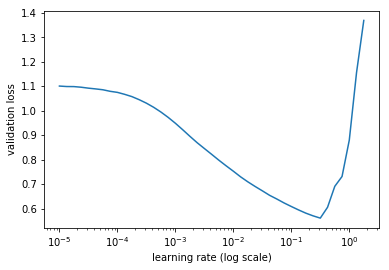

In [20]:
learn.sched.plot(0, 0)

In [21]:
lr=1e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])

In [22]:
# learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8), best_save_name='best')
learn.fit(lr, 8, best_save_name='best')

epoch      trn_loss   val_loss   dice_s     iou_s          
    0      0.253844   0.170665   0.872738   0.803941  
    1      0.209713   0.141803   0.9034     0.838884       
    2      0.192109   0.132348   0.918661   0.834734       
    3      0.18499    0.116945   0.923468   0.831317       
    4      0.179893   0.127824   0.916462   0.84073        
    5      0.176542   0.114604   0.926931   0.831691       
    6      0.173032   0.118663   0.924778   0.85533        
    7      0.170136   0.116354   0.929485   0.843242       


[0.11635403280217654, array(0.92948, dtype=float32), array(0.84324)]

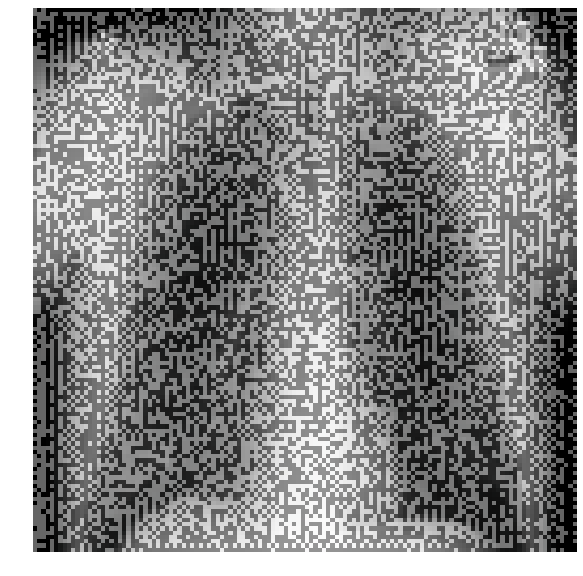

In [14]:
def plot_val():
    x, y = md.val_ds[10]
    py = torch.sigmoid(learn.model(V(x[None])))
    py = (py[0].cpu()>0.5).type(torch.FloatTensor) # py: ByteTensor (uint8) -> FloatTensor (float32)
    plot_lung_segment(denorm(x), to_pil(py))
plot_val()

In [203]:
learn.save('128urn-tmp')

In [204]:
learn.load('128urn-tmp')

In [24]:
learn.unfreeze()
learn.bn_freeze(True)

In [25]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   dice_s     iou_s          
    0      0.170401   0.105855   0.937278   0.864486  
    1      0.164437   0.102992   0.935232   0.871013       
    2      0.160757   0.103591   0.936429   0.878411       
    3      0.156353   0.099023   0.939885   0.882649       
    4      0.155456   0.097493   0.946238   0.875815       
    5      0.152831   0.101221   0.943096   0.887726       
    6      0.150406   0.089569   0.946151   0.876024       
    7      0.148128   0.091366   0.947964   0.874307       
    8      0.147617   0.088308   0.9475     0.869899       
    9      0.147748   0.088749   0.947478   0.881934       
    10     0.144423   0.088626   0.947682   0.880757       
    11     0.142308   0.081821   0.948736   0.872524       
    12     0.143476   0.090201   0.945284   0.880875       
    13     0.140866   0.084233   0.948835   0.882302       
    14     0.141302   0.091436   0.947682   0.888675       
    15     0.140816   0.08382    0.949143   0

[0.0824950384688445, array(0.94964, dtype=float32), array(0.87987)]

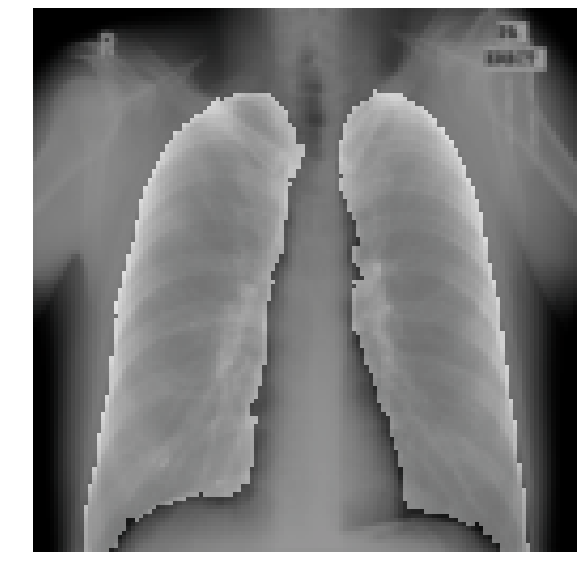

In [26]:
plot_val()

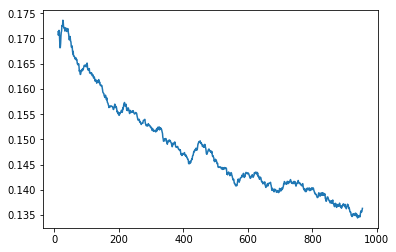

In [27]:
learn.sched.plot_loss()

## 512x512

In [28]:
md = get_md(sz=512, bs=4)
learn.set_data(md)

In [29]:
learn.lr_find()

 68%|██████▊   | 260/380 [00:25<00:14,  8.19it/s, loss=0.752]

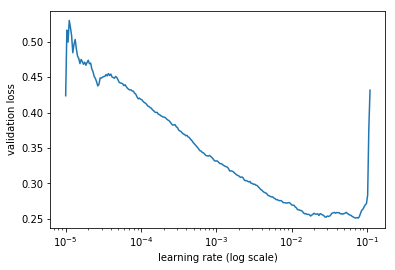

In [33]:
learn.sched.plot(0, 2)

In [34]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [35]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   dice_s     iou_s            
    0      0.216721   0.150934   0.905792   0.826013  
    1      0.190014   0.130929   0.916677   0.847195         
    2      0.176008   0.120907   0.922644   0.858779         
    3      0.178034   0.118748   0.927878   0.865626         
    4      0.168285   0.116274   0.927745   0.866349         


[0.11627369498564906, array(0.92774, dtype=float32), array(0.86635)]

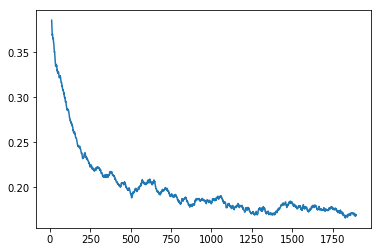

In [36]:
learn.sched.plot_loss()

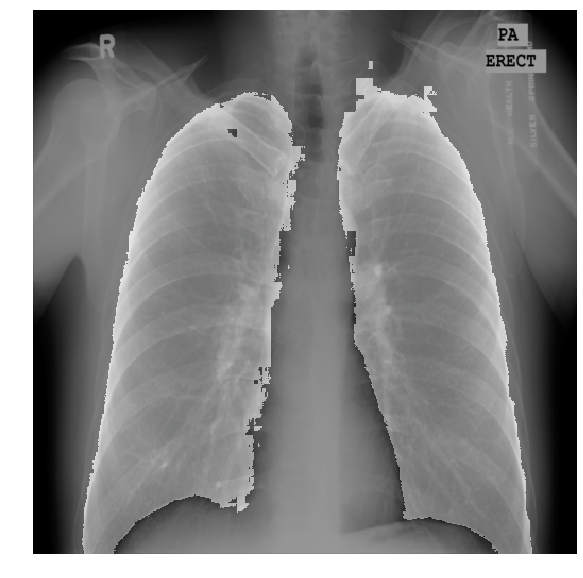

In [37]:
plot_val()

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   dice_s     iou_s            
    0      0.162302   0.104042   0.934223   0.872138  
    1      0.150393   0.088788   0.94765    0.899718         
    2      0.144396   0.089305   0.949649   0.905363         
    3      0.144496   0.085492   0.94956    0.900705         
    4      0.137085   0.08116    0.952757   0.907867         
    5      0.141866   0.082683   0.95174    0.905344         
    6      0.130162   0.081405   0.951867   0.909159         
    7      0.133074   0.080045   0.953664   0.910374         


[0.08004484034378198, array(0.95366, dtype=float32), array(0.91037)]

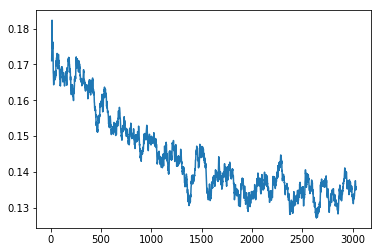

In [40]:
learn.sched.plot_loss()

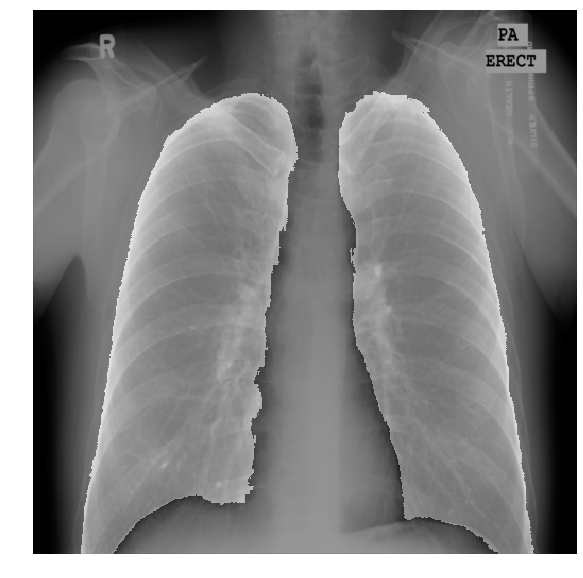

In [41]:
plot_val()

## 1024x1024

In [42]:
md = get_md(sz=1024, bs=1) # :))
learn.set_data(md)

In [43]:
learn.freeze_to(1)

In [44]:
learn.lr_find()

 35%|███▍      | 525/1520 [00:52<01:38, 10.06it/s, loss=0.298]

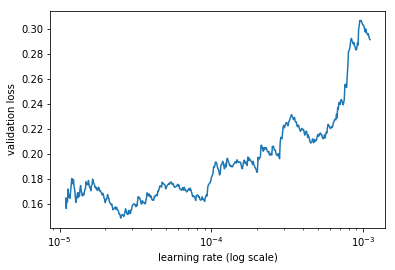

In [45]:
learn.sched.plot()

In [46]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/200,lr/30,lr])
# lrs = np.array([lr/100,lr/10,lr])

In [47]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   dice_s     iou_s              
    0      0.164976   0.104348   0.940758   0.886619  
    1      0.137457   0.081738   0.951829   0.907836           


[0.08173814221752264, array(0.95183, dtype=float32), array(0.90784)]

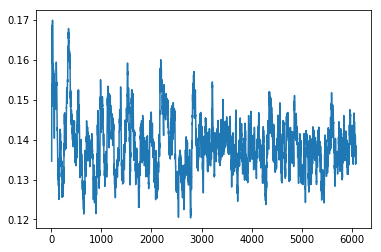

In [51]:
learn.sched.plot_loss()

In [52]:
learn.unfreeze()
learn.bn_freeze(True)

In [53]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   dice_s     iou_s              
    0      0.128986   0.082079   0.95296    0.910389  
    1      0.12918    0.082348   0.952909   0.910318           
    2      0.138065   0.082508   0.952973   0.910476           
    3      0.141739   0.082491   0.953097   0.910677           


[0.08249128791411267, array(0.9531, dtype=float32), array(0.91068)]

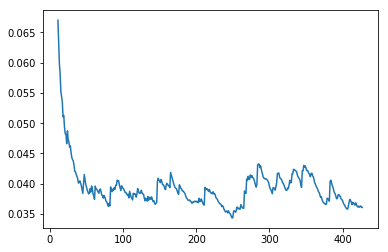

In [46]:
learn.sched.plot_loss()

In [47]:
learn.save('1024urn-tmp')

In [48]:
learn.lr_find()

 31%|███▏      | 34/108 [00:20<00:32,  2.30it/s, loss=0.136] 

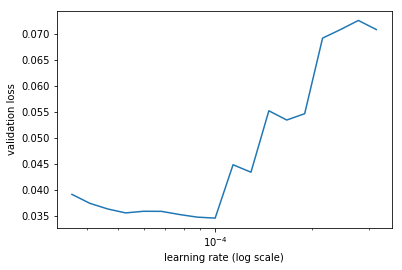

In [49]:
learn.sched.plot()

In [50]:
learn.save('1024')

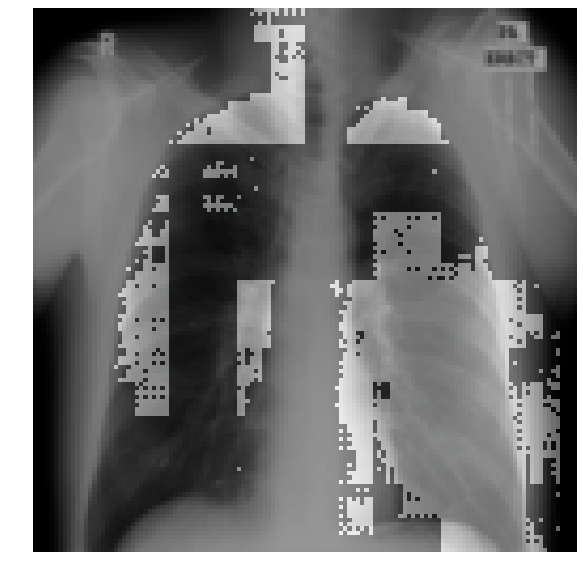

In [16]:
plot_val()

In [63]:
image = denorm(x.cpu().numpy())
torch.save(learn.model, '1024.pt')

/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Unet34. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dattran/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type UnetBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test on JSRT and Montgometry dataset

In [15]:
learn.load('1024')

In [18]:
def test(what='mont'):
    dl = get_test(256, 16, what)
    preds = []
    targs = []
    for x, y in iter(dl):
        x, y = VV(x), VV(y)
        pred = learn.model(x)

        targs.append(y.cpu())
        preds.append(pred.cpu())

    targs = torch.cat(targs)
    preds = torch.cat(preds)
    
    print(what, dice_s(preds, targs), iou_s(preds, targs))
    del targs, preds

test('mont')

mont tensor(0.7733) 0.6210702275223374


In [19]:
test('jsrt')

jsrt tensor(0.7364) 0.5754248763039834


In [25]:
test('jsrt')

jsrt tensor(0.7364) 0.5754248763039834


## Test on ChestX-ray 14 dataset

In [92]:
from scipy import ndimage
from matplotlib.patches import Rectangle

In [24]:
PATH = Path('/mnt/data/xray-thesis/data/chestX-ray14')
IMAGE_DN = 'images'
CSV_FILE = 'train_list.csv'
df = pd.read_csv(PATH/CSV_FILE)
image_names = df['image']

In [25]:
sample_image_names = np.random.choice(image_names, 16)

In [11]:
model = torch.load('1024.pt')
model = model.eval()

In [12]:
sz = 1024
arch = resnet34
_, tfms = tfms_from_model(arch, sz)

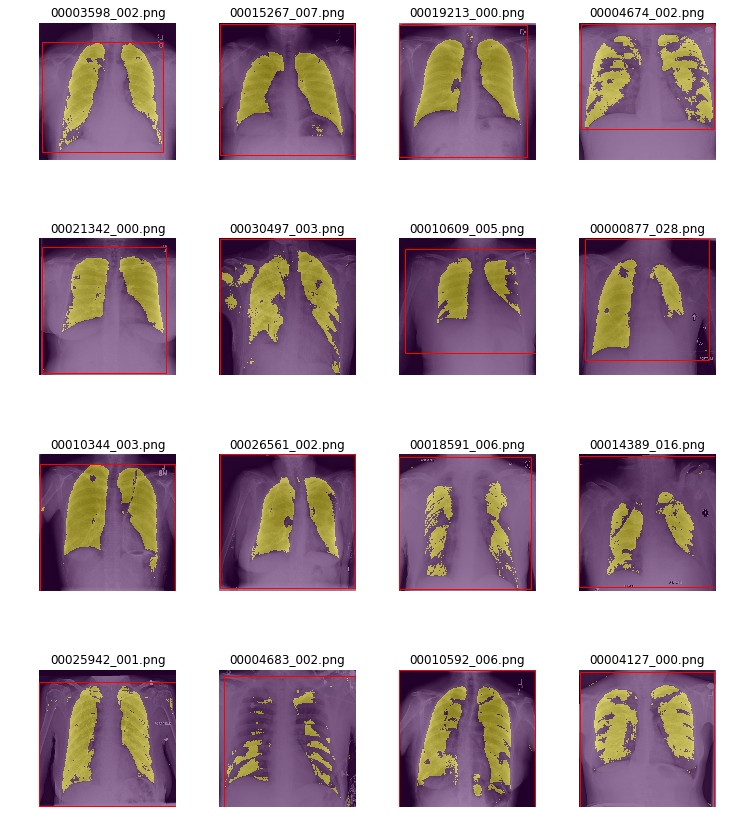

In [94]:
fig, axes = plt.subplots(4, 4, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    image = open_image(PATH/IMAGE_DN/sample_image_names[i])
    ax.set_title(sample_image_names[i])
    
    ax = show_img(image, ax=ax)
    image = Variable(torch.Tensor(tfms(image))[None]).cuda()
    py = to_np(model(image))
    show_img(py[0] > 3, ax=ax, alpha=0.5)
    
    slice_x, slice_y = ndimage.find_objects(py[0] > 0, True)[0]
    xy = (slice_y.start, slice_x.start)
    height = slice_x.stop - slice_x.start
    width= slice_y.stop - slice_y.start
    rect = Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.tight_layout(pad=0.1)

In [64]:
from scipy import ndimage
from matplotlib.patches import Rectangle

matplotlib.patches.Rectangle

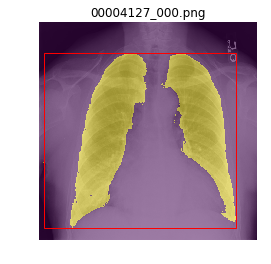

In [91]:
image_name = '00003598_002.png'
image = open_image(PATH/IMAGE_DN/image_name)
ax = show_img(image)
ax.set_title(sample_image_names[i])
data = Variable(torch.Tensor(tfms(image))[None]).cuda()
py = to_np(model(data))
show_img(py[0] > 0, ax=ax, alpha=0.5)
slice_x, slice_y = ndimage.find_objects(py[0] > 0, True)[0]
xy = (slice_y.start, slice_x.start)
height = slice_x.stop - slice_x.start
width= slice_y.stop - slice_y.start
rect = Rectangle(xy, width, height, linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)


In [90]:
xy, width, height

((145, 21), 824, 906)

In [86]:
# slice_x, slice_y = ndimage.find_objects(py[0] > 0, True)[0]

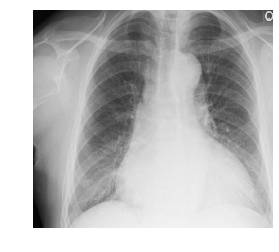

In [89]:
roi_image = image[slice_x.start:slice_x.stop, slice_y.start: slice_y.stop]
show_img(roi_image)
